In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
# using SharedArray
using Test

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
#         legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [3]:
c_enkf = colorant"cornflowerblue"
c_lowrank_85 = colorant"gold"
c_lowrank_95 = colorant"tomato2"
c_lowrank_99 = colorant"seagreen3"
c_lowrank_999 = colorant"peach"


c_locenkf = colorant"purple4"

In [4]:
Nv = 5
Nx = 3*Nv;

Ny = length(-2.0:0.5:16.0)

37

In [5]:
Ne = 30

rxhist_85 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_85.jld")["rxhist"]

ryhist_85 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_85.jld")["ryhist"];

rxhist_95 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_95.jld")["rxhist"]

ryhist_95 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_95.jld")["ryhist"];

rxhist_99 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_99.jld")["rxhist"]

ryhist_99 = load("/media/mat/HDD/LowRankVortex.jl/localization/data/metric_vortex_"*
         "lowrank_Ne_"*string(Ne)*"_ratio_99.jld")["ryhist"];

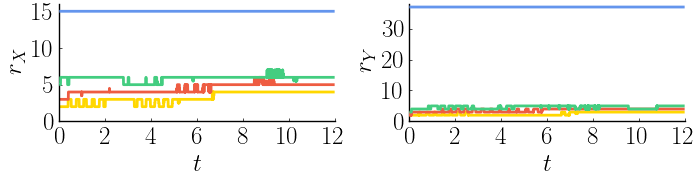

In [6]:
plt = plot(layout = grid(1, 2), xlims = (-Inf, Inf), xlabel = L"t", size = (700, 180))

plot!(plt[1,1], ylims = (0, 16), ylabel = L"r_{X}")
plot!(plt[1,1], (0.0:1e-3:12.0)[2:end], median(rxhist_85; dims = 1)[1,:], linewidth = 2, legend = false, 
     color = c_lowrank_85)
plot!(plt[1,1], (0.0:1e-3:12.0)[2:end], median(rxhist_95; dims = 1)[1,:], linewidth = 2, legend = false, 
     color = c_lowrank_95)
plot!(plt[1,1], (0.0:1e-3:12.0)[2:end], median(rxhist_99; dims = 1)[1,:], linewidth = 2, legend = false, 
      color = c_lowrank_99)
plot!(plt[1,1], 0.0:1e-3:12.0, [Nx], linewidth = 2, legend = false, color = c_enkf)
# annotate!(plt[1,1], 1.2, 12, L"(b)")


plot!(plt[1,2], ylims = (0, 38), ylabel = L"r_{Y}")
plot!(plt[1,2], (0.0:1e-3:12.0)[2:end], median(ryhist_85; dims = 1)[1,:], linewidth = 2, legend = false, 
      color = c_lowrank_85)
plot!(plt[1,2], (0.0:1e-3:12.0)[2:end], median(ryhist_95; dims = 1)[1,:], linewidth = 2, legend = false, 
      color = c_lowrank_95)
plot!(plt[1,2], (0.0:1e-3:12.0)[2:end], median(ryhist_99; dims = 1)[1,:], linewidth = 2, legend = false,
      color = c_lowrank_99)
plot!(plt[1,2], 0.0:1e-3:12.0, [Ny], linewidth = 2, legend = false, color = c_enkf)
# annotate!(plt[1,2], 1.2, 29, L"(c)")

# savefig("vortex_rank_Ne_"*string(Ne)*".pdf")

In [7]:
# Nelist = [10; 12; 15; 20; 25; 30; 40; 50; 60; 80; 100]
Nelist = [10; 12; 15; 20; 25; 30; 40; 50; 60; 80; 100]


q5_rmse_lowrank_85 = zeros(length(Nelist))
q25_rmse_lowrank_85 = zeros(length(Nelist))
q50_rmse_lowrank_85 = zeros(length(Nelist))
q75_rmse_lowrank_85 = zeros(length(Nelist))
q95_rmse_lowrank_85 = zeros(length(Nelist))

q5_rmse_lowrank_95 = zeros(length(Nelist))
q25_rmse_lowrank_95 = zeros(length(Nelist))
q50_rmse_lowrank_95 = zeros(length(Nelist))
q75_rmse_lowrank_95 = zeros(length(Nelist))
q95_rmse_lowrank_95 = zeros(length(Nelist))

q5_rmse_lowrank_99 = zeros(length(Nelist))
q25_rmse_lowrank_99 = zeros(length(Nelist))
q50_rmse_lowrank_99 = zeros(length(Nelist))
q75_rmse_lowrank_99 = zeros(length(Nelist))
q95_rmse_lowrank_99 = zeros(length(Nelist))

q5_rmse_lowrank_999 = zeros(length(Nelist))
q25_rmse_lowrank_999 = zeros(length(Nelist))
q50_rmse_lowrank_999 = zeros(length(Nelist))
q75_rmse_lowrank_999 = zeros(length(Nelist))
q95_rmse_lowrank_999 = zeros(length(Nelist))


q5_rmse_enkf = zeros(length(Nelist))
q25_rmse_enkf = zeros(length(Nelist))
q50_rmse_enkf = zeros(length(Nelist))
q75_rmse_enkf = zeros(length(Nelist))
q95_rmse_enkf = zeros(length(Nelist))

q5_rmse_localized_enkf = zeros(length(Nelist))
q25_rmse_localized_enkf = zeros(length(Nelist))
q50_rmse_localized_enkf = zeros(length(Nelist))
q75_rmse_localized_enkf = zeros(length(Nelist))
q95_rmse_localized_enkf = zeros(length(Nelist))

for (i, Nei) in enumerate(Nelist)
    @show Nei

    rmse_lowrank_85 = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
             "lowrank_Ne_"*string(Nei)*"_ratio_85.jld")["rmse"]
    
    q5_rmse_lowrank_85[i] = quantile(rmse_lowrank_85, 0.05)
    q25_rmse_lowrank_85[i] = quantile(rmse_lowrank_85, 0.25)
    q50_rmse_lowrank_85[i] = quantile(rmse_lowrank_85, 0.50)
    q75_rmse_lowrank_85[i] = quantile(rmse_lowrank_85, 0.75)
    q95_rmse_lowrank_85[i] = quantile(rmse_lowrank_85, 0.95)
    
    rmse_lowrank_95 = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
             "lowrank_Ne_"*string(Nei)*"_ratio_95.jld")["rmse"]
    
    q5_rmse_lowrank_95[i] = quantile(rmse_lowrank_95, 0.05)
    q25_rmse_lowrank_95[i] = quantile(rmse_lowrank_95, 0.25)
    q50_rmse_lowrank_95[i] = quantile(rmse_lowrank_95, 0.50)
    q75_rmse_lowrank_95[i] = quantile(rmse_lowrank_95, 0.75)
    q95_rmse_lowrank_95[i] = quantile(rmse_lowrank_95, 0.95)
    
    rmse_lowrank_99 = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
             "lowrank_Ne_"*string(Nei)*"_ratio_99.jld")["rmse"]
    
    q5_rmse_lowrank_99[i] = quantile(rmse_lowrank_99, 0.05)
    q25_rmse_lowrank_99[i] = quantile(rmse_lowrank_99, 0.25)
    q50_rmse_lowrank_99[i] = quantile(rmse_lowrank_99, 0.50)
    q75_rmse_lowrank_99[i] = quantile(rmse_lowrank_99, 0.75)
    q95_rmse_lowrank_99[i] = quantile(rmse_lowrank_99, 0.95)
    
    
    rmse_lowrank_999 = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
             "lowrank_Ne_"*string(Nei)*"_ratio_999.jld")["rmse"]
    
    q5_rmse_lowrank_999[i] = quantile(rmse_lowrank_999, 0.05)
    q25_rmse_lowrank_999[i] = quantile(rmse_lowrank_999, 0.25)
    q50_rmse_lowrank_999[i] = quantile(rmse_lowrank_999, 0.50)
    q75_rmse_lowrank_999[i] = quantile(rmse_lowrank_999, 0.75)
    q95_rmse_lowrank_999[i] = quantile(rmse_lowrank_999, 0.95)
    
    if (Nei >= 25) == true
        rmse_enkf = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
                         "enkf_Ne_"*string(Nei)*".jld")["rmse"]
        
#     rmse_enkf *= 1/length(1601:2401)^2
            q5_rmse_enkf[i] = quantile(rmse_enkf, 0.05)
            q25_rmse_enkf[i] = quantile(rmse_enkf, 0.25)
            q50_rmse_enkf[i] = quantile(rmse_enkf, 0.50)
            q75_rmse_enkf[i] = quantile(rmse_enkf, 0.75)
            q95_rmse_enkf[i] = quantile(rmse_enkf, 0.95)
    end
    
    rmse_localized_enkf = load("/media/mat/HDD/LowRankVortex.jl/localization/data2/metric_vortex_"*
                         "localized_enkf_Ne_"*string(Nei)*".jld")["rmse"]
        
#     rmse_enkf *= 1/length(1601:2401)^2
            q5_rmse_localized_enkf[i] = quantile(rmse_localized_enkf, 0.05)
            q25_rmse_localized_enkf[i] = quantile(rmse_localized_enkf, 0.25)
            q50_rmse_localized_enkf[i] = quantile(rmse_localized_enkf, 0.50)
            q75_rmse_localized_enkf[i] = quantile(rmse_localized_enkf, 0.75)
            q95_rmse_localized_enkf[i] = quantile(rmse_localized_enkf, 0.95)
    
    
end

Nei = 10
Nei = 12
Nei = 15
Nei = 20
Nei = 25
Nei = 30
Nei = 40
Nei = 50
Nei = 60
Nei = 80
Nei = 100


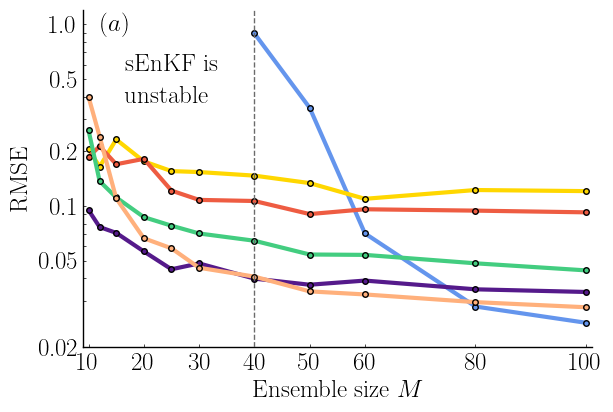

In [44]:
ratiolist = [85; 95; 99; 999]

Neb = 7


Neplot = [10; 20; 30 ; 40; 50; 60; 80; 100]
RMSEplot = [2e-2;3e-2;4e-2;5e-2;6e-2;7e-2;8e-2;9e-2;1e-1;2e-1;3e-1;4e-1;5e-1;6e-1;7e-1;8e-1;9e-1;1.0]
# Neplot = [10; 15; 20; 25; 30; 40; 50; 60; 80; 100]


plt = plot(xlabel = "Ensemble size "*L"M", ylabel = "RMSE", yscale = :log10,
           xlims = (9, 101), xticks = (Neplot, string.(Neplot)), 
           ylims = (-Inf, 1.2), 
           yticks = (RMSEplot, map(i-> ifelse(i ∈ [0.01; 0.02; 0.05; 0.1; 0.2; 0.5; 1.0], string(i), ""), RMSEplot)),
           legend = false)#, size = (600, 300))

# plot!(plt, Nelist[Neb:end], q5_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf, 
#       label = "")
# plot!(plt, Nelist[Neb:end], q25_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
#       label = "")
plot!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 3, linestyle = :solid, color = c_enkf,
      label = "Adaptive low-rank EnKF")
# plot!(plt, Nelist[Neb:end], [q50_rmse_enkf[Neb:end] q50_rmse_enkf[Neb:end]], linewidth = 0.0,
#     fillrange = [q25_rmse_enkf[Neb:end] q75_rmse_enkf[Neb:end]], alpha = 0.1, color = c_enkf,
#       label = "")
# plot!(plt, Nelist[Neb:end], q75_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
#       label = "")

# plot!(plt, Nelist[Neb:end], q95_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
#       label = "")

scatter!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
      label = "")


# plot!(plt, Nelist[Neb:end], q5_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf, 
#       label = "")
# plot!(plt, Nelist, q25_rmse_localized_enkf, linewidth = 2, linestyle = :dash, color = c_locenkf,
#       label = "")
plot!(plt, Nelist, q50_rmse_localized_enkf, linewidth = 3, linestyle = :solid, color = c_locenkf,
      label = "Adaptive low-rank EnKF")
# plot!(plt, Nelist, [q50_rmse_localized_enkf q50_rmse_localized_enkf], linewidth = 0.0,
#     fillrange = [q25_rmse_localized_enkf q75_rmse_localized_enkf], alpha = 0.1, color = c_locenkf,
#       label = "")
# plot!(plt, Nelist, q75_rmse_localized_enkf, linewidth = 2, linestyle = :dash, color = c_locenkf,
#       label = "")

# plot!(plt, Nelist[Neb:end], q95_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
#       label = "")

scatter!(plt, Nelist, q50_rmse_localized_enkf, linewidth = 2, linestyle = :dot, color = c_locenkf,     
      label = "")


for ratio in ratiolist
    
    c_ratio = eval(Symbol("c_lowrank_"*string(ratio)))
    
    q5 = eval(Symbol("q5_rmse_lowrank_"*string(ratio)))
    q25 = eval(Symbol("q25_rmse_lowrank_"*string(ratio)))
    q50 = eval(Symbol("q50_rmse_lowrank_"*string(ratio)))
    q75 = eval(Symbol("q75_rmse_lowrank_"*string(ratio)))
    q95 = eval(Symbol("q95_rmse_lowrank_"*string(ratio)))
    
#     plot!(plt, Nelist, q5, linewidth = 2, linestyle = :dot, 
#           color = c_ratio, label = "")
#     plot!(plt, Nelist, q25, linewidth = 2, linestyle = :dash, color = c_ratio,
#           label = "")
    plot!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
#     plot!(plt, Nelist, [q50  q50], linewidth = 0.0,
#           fillrange = [q25  q75], alpha = 0.1, color = c_ratio,
#           label = "")  
#     plot!(plt, Nelist, q75, linewidth = 2, linestyle = :dash, color = c_ratio,
#           label = "")
#     plot!(plt, Nelist, q95, linewidth = 2, linestyle = :dot, color = c_ratio,
#           label = "")
    scatter!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
end

vline!(plt, [40], color = :gray42, linestyle = :dash)
annotate!(plt, [(25, 0.6, "sEnKF is")])
annotate!(plt, [(24, 0.4, "unstable")])

annotate!(plt, [(15, 1.0, L"(a)")])

plt

savefig("vortex_log_RMSE_enkf_localized_lowrank.pdf")

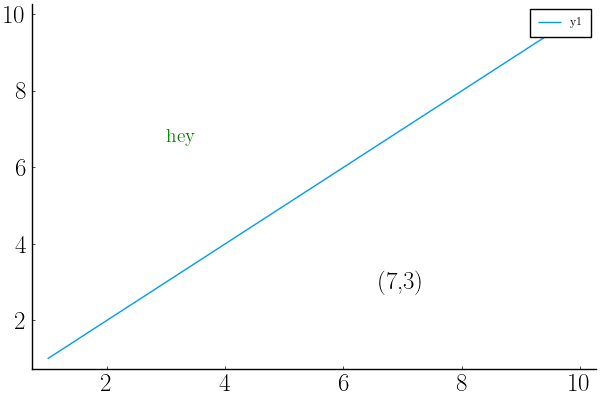

In [34]:
plot(1:10)
annotate!([(7,3,"(7,3)"),(3,7,text("hey", 14, :left, :top, :green))])

In [27]:
?annotate!

search: annotate! CardinalMonotonicInterpolation



```
annotate!(anns)
annotate!(anns::Tuple...)
annotate!(x, y, txt)
```

Add annotations to an existing plot. Annotations are specified either as a vector of tuples, each of the form `(x,y,txt)`, or as three vectors, `x, y, txt`. Each `txt` can be a `String`, `PlotText` PlotText (created with `text(args...)`), or a tuple of arguments to `text` (e.g., `("Label", 8, :red, :top)`).

# Example

```julia-repl
julia> plot(1:10)
julia> annotate!([(7,3,"(7,3)"),(3,7,text("hey", 14, :left, :top, :green))])
julia> annotate!([(4, 4, ("More text", 8, 45.0, :bottom, :red))])
julia> annotate!([2,5], [6,3], ["text at (2,6)", "text at (5,3)"])
```


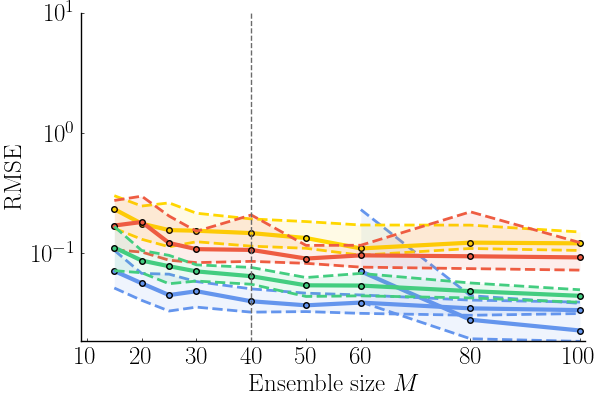

In [9]:
ratiolist = [85; 95; 99]

Neb = 7


Neplot = [10; 20; 30 ; 40; 50; 60; 80; 100]
# Neplot = [10; 15; 20; 25; 30; 40; 50; 60; 80; 100]



plt = plot(xlabel = "Ensemble size "*L"M", ylabel = "RMSE", ylims = (-Inf, 10), yscale = :log10,
           xlims = (9, 101), xticks = (Neplot, string.(Neplot)), legend = false)#, size = (600, 300))

# plot!(plt, Nelist[Neb:end], q5_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf, 
#       label = "")
plot!(plt, Nelist[Neb:end], q25_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")
plot!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 3, linestyle = :solid, color = c_enkf,
      label = "Adaptive low-rank EnKF")
plot!(plt, Nelist[Neb:end], [q50_rmse_enkf[Neb:end] q50_rmse_enkf[Neb:end]], linewidth = 0.0,
    fillrange = [q25_rmse_enkf[Neb:end] q75_rmse_enkf[Neb:end]], alpha = 0.1, color = c_enkf,
      label = "")
plot!(plt, Nelist[Neb:end], q75_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")

# plot!(plt, Nelist[Neb:end], q95_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
#       label = "")

scatter!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
      label = "")


# plot!(plt, Nelist[Neb:end], q5_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf, 
#       label = "")
plot!(plt, Nelist, q25_rmse_localized_enkf, linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")
plot!(plt, Nelist, q50_rmse_localized_enkf, linewidth = 3, linestyle = :solid, color = c_enkf,
      label = "Adaptive low-rank EnKF")
plot!(plt, Nelist, [q50_rmse_localized_enkf q50_rmse_localized_enkf], linewidth = 0.0,
    fillrange = [q25_rmse_localized_enkf q75_rmse_localized_enkf], alpha = 0.1, color = c_enkf,
      label = "")
plot!(plt, Nelist, q75_rmse_localized_enkf, linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")

# plot!(plt, Nelist[Neb:end], q95_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
#       label = "")

scatter!(plt, Nelist, q50_rmse_localized_enkf, linewidth = 2, linestyle = :dot, color = c_enkf,     
      label = "")


for ratio in ratiolist
    
    c_ratio = eval(Symbol("c_lowrank_"*string(ratio)))
    
    q5 = eval(Symbol("q5_rmse_lowrank_"*string(ratio)))
    q25 = eval(Symbol("q25_rmse_lowrank_"*string(ratio)))
    q50 = eval(Symbol("q50_rmse_lowrank_"*string(ratio)))
    q75 = eval(Symbol("q75_rmse_lowrank_"*string(ratio)))
    q95 = eval(Symbol("q95_rmse_lowrank_"*string(ratio)))
    
#     plot!(plt, Nelist, q5, linewidth = 2, linestyle = :dot, 
#           color = c_ratio, label = "")
    plot!(plt, Nelist, q25, linewidth = 2, linestyle = :dash, color = c_ratio,
          label = "")
    plot!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
    plot!(plt, Nelist, [q50  q50], linewidth = 0.0,
          fillrange = [q25  q75], alpha = 0.1, color = c_ratio,
          label = "")  
    plot!(plt, Nelist, q75, linewidth = 2, linestyle = :dash, color = c_ratio,
          label = "")
#     plot!(plt, Nelist, q95, linewidth = 2, linestyle = :dot, color = c_ratio,
#           label = "")
    scatter!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
end

vline!(plt, [40], color = :gray42, linestyle = :dash)
# annotate!(plt, 25, 0.7, "sEnKF is ")
# annotate!(plt, 24, 0.6, "unstable")
# annotate!(plt, 15, 1.0,  L"(a)")

plt

# savefig("vortex_RMSE_enkf_lowrank.pdf")

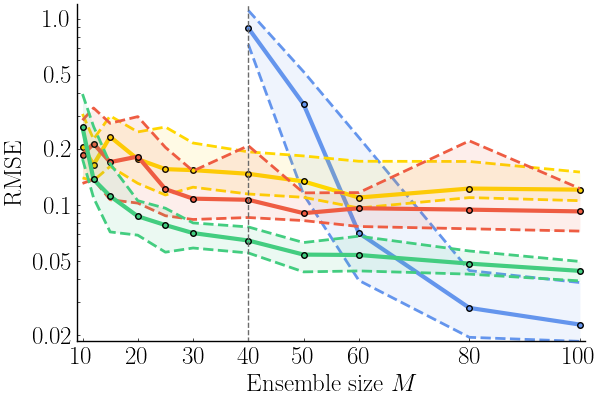

In [16]:
ratiolist = [85; 95; 99]

Neb = 7


Neplot = [10; 20; 30 ; 40; 50; 60; 80; 100]
RMSEplot = [2e-2;3e-2;4e-2;5e-2;6e-2;7e-2;8e-2;9e-2;1e-1;2e-1;3e-1;4e-1;5e-1;6e-1;7e-1;8e-1;9e-1;1.0]


plt = plot(xlabel = "Ensemble size "*L"M", ylabel = "RMSE",
           xlims = (9, 101), xticks = (Neplot, string.(Neplot)), 
           ylims = (-Inf, 1.2), 
           yticks = (RMSEplot, map(i-> ifelse(i ∈ [0.01; 0.02; 0.05; 0.1; 0.2; 0.5; 1.0], string(i), ""), RMSEplot)),
           yscale = :log10, 
           legend = false)#, size = (600, 300))

# plot!(plt, Nelist[Neb:end], q5_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf, 
#       label = "")
plot!(plt, Nelist[Neb:end], q25_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")
plot!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 3, linestyle = :solid, color = c_enkf,
      label = "Adaptive low-rank EnKF")
plot!(plt, Nelist[Neb:end], [q50_rmse_enkf[Neb:end] q50_rmse_enkf[Neb:end]], linewidth = 0.0,
    fillrange = [q25_rmse_enkf[Neb:end] q75_rmse_enkf[Neb:end]], alpha = 0.1, color = c_enkf,
      label = "")
plot!(plt, Nelist[Neb:end], q75_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dash, color = c_enkf,
      label = "")

# plot!(plt, Nelist[Neb:end], q95_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
#       label = "")

scatter!(plt, Nelist[Neb:end], q50_rmse_enkf[Neb:end], linewidth = 2, linestyle = :dot, color = c_enkf,     
      label = "")


for ratio in ratiolist
    
    c_ratio = eval(Symbol("c_lowrank_"*string(ratio)))
    
    q5 = eval(Symbol("q5_rmse_lowrank_"*string(ratio)))
    q25 = eval(Symbol("q25_rmse_lowrank_"*string(ratio)))
    q50 = eval(Symbol("q50_rmse_lowrank_"*string(ratio)))
    q75 = eval(Symbol("q75_rmse_lowrank_"*string(ratio)))
    q95 = eval(Symbol("q95_rmse_lowrank_"*string(ratio)))
    
#     plot!(plt, Nelist, q5, linewidth = 2, linestyle = :dot, 
#           color = c_ratio, label = "")
    plot!(plt, Nelist, q25, linewidth = 2, linestyle = :dash, color = c_ratio,
          label = "")
    plot!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
    plot!(plt, Nelist, [q50  q50], linewidth = 0.0,
          fillrange = [q25  q75], alpha = 0.1, color = c_ratio,
          label = "")  
    plot!(plt, Nelist, q75, linewidth = 2, linestyle = :dash, color = c_ratio,
          label = "")
#     plot!(plt, Nelist, q95, linewidth = 2, linestyle = :dot, color = c_ratio,
#           label = "")
    scatter!(plt, Nelist, q50, linewidth = 3, linestyle = :solid, color = c_ratio, 
          label = "")
end

vline!(plt, [40], color = :gray42, linestyle = :dash)
# annotate!(plt, 25, 0.50, "sEnKF is ")
# annotate!(plt, 24, 0.35, "unstable")
# annotate!(plt, 15, 0.9,  L"(a)")

plt

# savefig("vortex_log_RMSE_enkf_lowrank.pdf")